<a href="https://colab.research.google.com/github/surajsrivathsa/ovgu_deeplearning/blob/master/Assignment_10_Adverserial_Examples_and_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning programming task

**Assignment 10:** Adverserial Examples and Training

**Team members:**
1. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de
2. Aditya Dey : 230580 : aditya.dey@st.ovgu.de
3. Suraj Shashidhar: 230052 : suraj.shashidhar@st.ovgu.de

**We have not completely done the introspection part of maximizing activations, we have tried to cover this stuff with limited capacity**

**Tasks to be done**

1) **Creating Adverserial examples**

**White box attacks: Attack models by using its parameters or learned knowledge**

**Non-targeted adversarial attack:** the most general type of attack when all you want to do is to make the classifier give an incorrect result.

**Targeted adversarial attack:** A slightly more difficult attack which aims to receive a particular class for your input.

a) **Untargeted Attack**: We don't apply any distinction on which type of input we are trying to morph and also what it should be morphed into. For example: 3 could be morphed to 0 and another 3 could be morphed to 1, there is no targeting. Hence we simply device methods to increase loss through out inputs rather than picking a distinct input/output mapping.

- Train the simple mlp based model on MNSIT(because MNSIT is simple and has only one channel)

- After training, Take a batch of inputs that were used in training(preferably the batch that has all the class labels).

- Run it through a customized gradient tape, where you calculate loss between input image vs output prediction and not between output prediction vs actual label. This is similar to whats done in neural style transfer where we update input image pixel values based on gradients.

- Instead of reducing the loss from input we would be somewhat increasing it by adding the weighted computed gradient to input image. If we subtract the gradients we would not be targeting rather than making input much better for classifictaion. We also weigh the gradients by learning rate so that the applied loss doesn't change the image too much visually

- We can have different types of weighing schemes instead of multiplying with a learning rate. First one is normalize each gradienbt of the pixel to a unit vector or some vector with constant magnitude. We can also do a gradient sign method. Any other schemes are alo welcome?

- Normalize the image pixels values again to be inside [0,1] range.

- Run it through the prediction to see the wrongly classified images.

b) **Targeted attack**: Make the network break for specific type of inputs-output mapping. for example make all inputs to be classified as 1 or 7.

**Black box attacks:** Attack the model without knowing its parameters or gradients **Check reference 6**

Black-box Adversarial Attacks with Limited Queries and Information : https://arxiv.org/pdf/1804.08598.pdf

- Do adversarial attacks actually pose a threat to DL-systems in the real-world **Check Reference 1**

- Introspection with Activation maximization

2) **Adverserial Training**

- Integrate adverserial examples into training loop. First run a batch of input and compute loss(predicted vs actual class). Create adverserial examples for the same batch using loss(predicted label vs input image). Do a normal backprop using both the losses or only adverseril loss through ther network.

- Test the network with similar but new adverserial examples and see its performance improves.

- See if the untargeted adverserial training is robust against the targeted training examples or some other method such as multiple gradient steps.

**Cross Model Attacks** 

**Horizontal Attacks:** This makes adverserial attacks too hard to defend across multiple models as the same adverserial image is more likely to fool multiple network withou much changes. Some of the images that corrput VGG based CNN can also corrupt Densenets/Inception net without much effort.

This is also true for NLP models like RNNs, Transformers.

**Vertical Attacks:** Especially in transfer learning as most of the production applications are transfer learnt from VGG/DEnse net/Inception net. If we break one we can break its vertical.

It is exteremly tricky as if we can corrupt transformers then we can surely corrput GPT, BERT and any model thats running currently that has been fine tuned on these models.

**Poisioning Bert model:** https://www.linkedin.com/posts/huggingface_nlproc-machinelearning-datascience-activity-6682314900712275968-tdUZ

**Strategies used to defend against adverserial attacks:**

p) **Reactive strategy:** Next to our normal classifier, train another adverserial classfier. Run input through both of them, if the adverserial classifies this as false input then throw away the predicted results. This strategy is problematic as we need infrastructure to handle both the models and also need to retrain both of them periodically.

q) **Proactive strategy:** Generate adverserial example from the input image and use them in training loop again. We would have only one model, but more training is required than reactive one. 

**References:**

1) **Overview blog 1**: https://medium.com/@ml.at.berkeley/tricking-neural-networks-create-your-own-adversarial-examples-a61eb7620fd8 | https://blog.ycombinator.com/how-adversarial-attacks-work/

2) **Overview Blog 2**: https://openai.com/blog/adversarial-example-research/#:~:text=Machine%20Learning-,with%20Adversarial,like%20optical%20illusions%20for%20machines.  | https://distill.pub/2018/building-blocks/

3) **Book**: https://christophm.github.io/interpretable-ml-book/

4) **Library for adverserial attacks**: https://github.com/tensorflow/cleverhans

5) **Untargeted attack Gradient sign**: https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

6) **Blackbox attack**: https://christophm.github.io/interpretable-ml-book/adversarial.html

7) **Activation maximization**: https://distill.pub/2017/feature-visualization/

8) **Does adverserial training hurts the original data?**: https://arxiv.org/pdf/1906.06032.pdf

9) **Explaining and harnessing adverserial examples:** https://arxiv.org/abs/1412.6572

10) **Adversarial Examples: Opportunities and Challenges:** https://arxiv.org/abs/1809.04790

11) **Overview blog 3:** https://github.com/dangeng/Simple_Adversarial_Examples

12) **One Pixel attack for fooling neural networks:** https://arxiv.org/pdf/1710.08864.pdf. | https://distill.pub/2019/advex-bugs-discussion/

In [ ]:
import os
%tensorflow_version 2.x
import tensorflow as tf
from sklearn import preprocessing
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import copy
import numpy as np
from datasets import MNISTDataset

In [ ]:

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import initializers
import tensorboard
import time
from datetime import datetime
from keras import backend as K

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
[0 4 1 9 2 1 3 1 4]


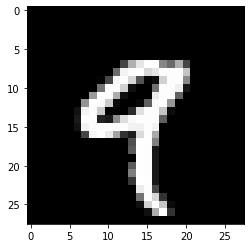

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
plt.imshow(train_images[4], cmap="Greys_r")
print(train_labels[1:10])

In [ ]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)
print(train_images.reshape([-1, 784]).shape)

(60000, 784)


In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


# Creating and pretraining a simple MLP model

In [ ]:
def create_mlp_model(input_shape=(28, 28), layer_dims=[256,128,64,32,10],output_activation="softmax",hidden_activation="relu"):
  model = keras.Sequential([keras.layers.Flatten(input_shape=input_shape)])
  #Loop till penultimate layer that is the penultimate decoder
  for i in range (len(layer_dims)-1):
    model.add(tf.keras.layers.Dense(units=layer_dims[i],activation=hidden_activation))
  
  #Add the output at end
  model.add(tf.keras.layers.Dense(units=layer_dims[-1],activation=output_activation)) 
  return model;

In [ ]:
mlp_model = create_mlp_model()

In [ ]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
__________________________________________________

In [ ]:
def compile_mlp_model(model,loss="CCE", metrics=["accuracy"], optimizer = "adam"):
  if(loss == "MAE"):
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MAE, metrics=metrics)
  elif (loss == "MSQE"):
    model.compile(optimizer=optimizer, loss=tf.keras.losses.mean_squared_error, metrics=metrics)
  elif (loss == "BCE"):
    model.compile(optimizer=optimizer, loss=tf.keras.losses.binary_crossentropy, metrics=metrics)
  elif(loss == "CCE"):
    model.compile(optimizer=optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=metrics)

In [ ]:
compile_mlp_model(mlp_model,loss="CCE")

In [ ]:
mlp_model.fit(train_images, train_labels,  epochs=7, batch_size=128, validation_data= (test_images, test_labels))

Epoch 1/7
469/469 [==============================] - 3s 7ms/step - loss: 1.1659 - accuracy: 0.8289 - val_loss: 0.2792 - val_accuracy: 0.9292
Epoch 2/7
469/469 [==============================] - 3s 6ms/step - loss: 0.2252 - accuracy: 0.9390 - val_loss: 0.2079 - val_accuracy: 0.9463
Epoch 3/7
469/469 [==============================] - 3s 7ms/step - loss: 0.1485 - accuracy: 0.9573 - val_loss: 0.1632 - val_accuracy: 0.9578
Epoch 4/7
469/469 [==============================] - 3s 7ms/step - loss: 0.1142 - accuracy: 0.9669 - val_loss: 0.1544 - val_accuracy: 0.9589
Epoch 5/7
469/469 [==============================] - 3s 7ms/step - loss: 0.0929 - accuracy: 0.9718 - val_loss: 0.1417 - val_accuracy: 0.9649
Epoch 6/7
469/469 [==============================] - 3s 6ms/step - loss: 0.0810 - accuracy: 0.9758 - val_loss: 0.1508 - val_accuracy: 0.9651
Epoch 7/7
469/469 [==============================] - 3s 6ms/step - loss: 0.0767 - accuracy: 0.9771 - val_loss: 0.1384 - val_accuracy: 0.9657


# Creating Adverserial Examples

1) **Untargeted attack:** We performed untargeted attack using categorical crossentropy and mean squared error loss. We also tried three types of attack just multplying, unit vactor, gradient sign.

**Learnings:** Decision boundaries between different labels are really simple and not complex as assumed earlier, even some carefully constructed perturbations can cause label to flip. 

This is compounded by the fact that while training we cannot cover every type of image. Even random noise would be classified as some digit albeit with very less probability. 

Hence we also need to have a separate garbage class to atleast capture some these garbage noisy images. 

However image space is huge with around 786^255 combinations hence all this space cannot be covered.

2) **Targeted attack:** We performed targeted attack too and tried to convert images to value 2. 

**Learnings:** even though we got okayish images we can see the potential of making every image classify as 2. 

This is done by adding additional term to loss function which aims to take difference between target and source image and tries to minimize it.


**Black Box attacks:** Attacking the model without having access to its gradients or output distributions(gives only one label as output or some labels with rank/confidence values and not probabilities) or limited query setting(cannot run for huge batches to emulate the gradient of network).

**Access to gradient:** This is possible but time consuming, send huge batches of training data to original model and get the predictions back.

Use this predictions in your new model and optimize your network weights according to predictions of original model. We end up with a model which is almost duplicate of ours and we can create adverserial examples on our own.

**Hampered Output distributions:** Use a sampling algorithm like montecarlo to create a proxy for softmax output. For example:
First send image + noise --> record output rank/confidence, image + 2*noise --> record output ranks/confidence, image + 3* noise --> record output ranks/confidence, run this experiment and finally use montecarlo with some approximation formulaes to arrive to approximate output distribution for class label

**Black-box Adversarial Attacks with Limited Queries and Information** https://arxiv.org/pdf/1804.08598.pdf

**Do adversarial attacks actually pose a threat to DL-systems in the real-world?**

Yes,  adverserial attacks along with relative inexplainablity of Depp neural networks would inhibit its deployment in mission critical applications that may impact humans directly such as medical/self driving cars/financial institutions/government offices. But it still can be used where errors made don't significantly impact human life directly such as search engines, nlp

Untargeted attack

In [ ]:
adverserial_training_images_batch = tf.convert_to_tensor(train_images[0:1024, :, :], dtype=tf.float32)
adverserial_test_images_batch = tf.convert_to_tensor(test_images[0:1024, :, :], dtype=tf.float32)
adverserial_training_labels_batch = tf.convert_to_tensor(train_labels[0:1024], dtype=tf.float32)
adverserial_test_labels_batch = tf.convert_to_tensor(test_labels[0:1024], dtype=tf.float32)
print(adverserial_training_images_batch.shape)
print(adverserial_test_images_batch.shape)
print(adverserial_training_labels_batch.shape)
print(adverserial_test_labels_batch.shape)

(1024, 28, 28)
(1024, 28, 28)
(1024,)
(1024,)


In [ ]:
adverserial_test_labels_batch

<tf.Tensor: shape=(1024,), dtype=float32, numpy=array([7., 2., 1., ..., 7., 5., 4.], dtype=float32)>

In [ ]:
test_onehot = tf.one_hot(indices = tf.cast(adverserial_test_labels_batch, dtype=tf.dtypes.int64), depth=10)
print(test_onehot)
test_onehot.shape

tf.Tensor(
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(1024, 10), dtype=float32)


TensorShape([1024, 10])

In [ ]:
def create_adversarial_pattern(adverserial_training_images_batch, adverserial_training_labels_batch, perturbation_type="multiply", 
                               attack_type = "untargeted", targeted_attack_images = None, loss_fnc = "CCE", lmbda = 0.05, multiply_factor=1000000):
  with tf.GradientTape() as tape:
    tape.watch(adverserial_training_images_batch)
    prediction = mlp_model(adverserial_training_images_batch)

    #Two loss functions for targeted and untargeted
    if(attack_type == "untargeted" and loss_fnc == "CCE"):
      loss = tf.keras.losses.sparse_categorical_crossentropy(adverserial_training_labels_batch, prediction)
    elif(attack_type == "untargeted" and loss_fnc == "MSE"):
      one_hot_test_labels = tf.one_hot(indices = tf.cast(adverserial_training_labels_batch, dtype=tf.dtypes.int64), depth=10)
      loss = tf.keras.losses.mean_squared_error(one_hot_test_labels, prediction)
    elif(attack_type == "targeted" and loss_fnc == "MSE"):
      one_hot_test_labels = tf.one_hot(indices = tf.cast(adverserial_training_labels_batch, dtype=tf.dtypes.int64), depth=10)
      #print(one_hot_test_labels.shape)
      #print(prediction.shape)
      #print(adverserial_training_images_batch.shape)
      #print(targeted_attack_images.shape)
      y_loss = lmbda * tf.keras.losses.mean_squared_error(adverserial_training_images_batch, targeted_attack_images)
      #print(y_loss.shape)
      targeting_image_loss = tf.reduce_sum(y_loss,axis = 1)
      #print(targeting_image_loss.shape)
      loss = tf.keras.losses.mean_squared_error(one_hot_test_labels, prediction) + targeting_image_loss
    else:
      print("Only two types of attacks are possible untargeted and targeted, you have given {}. Aborting".format(attack_type))
      return [None, None]

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, adverserial_training_images_batch)
  # Get the sign of the gradients to create the perturbation
  #signed_grad = tf.sign(gradient)
  if(perturbation_type == "multiply"):
    perturbations = multiply_factor * gradient
  elif(perturbation_type == "unit_vector"):
    z = gradient
    norm = tf.sqrt(tf.reduce_sum(tf.square(z), axis=[-1,-2], keepdims=True))
    perturbations = z/norm
  elif(perturbation_type == "gradient_sign"):
    perturbations = tf.sign(gradient)
  else:
    perturbations = gradient
  return [gradient, perturbations];

In [ ]:
gradient, perturbations = create_adversarial_pattern(adverserial_training_images_batch, adverserial_training_labels_batch)

(1024, 10)


In [ ]:
perturbations.shape

TensorShape([1024, 28, 28])

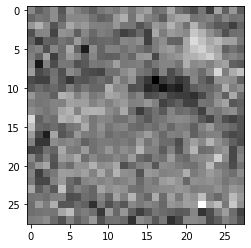

In [ ]:
plt.imshow(perturbations[0,:,:], cmap=plt.cm.binary)

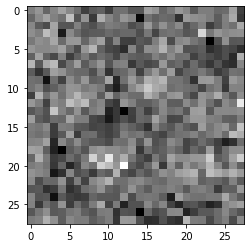

In [ ]:
plt.imshow(perturbations[3,:,:], cmap=plt.cm.binary)

In [ ]:
print(perturbations[3,:,:])
print(gradient[3:, :, :])

In [ ]:
adverserial_training_images_batch_modified = tf.add(adverserial_training_images_batch, perturbations)

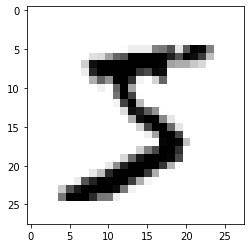

In [ ]:
plt.imshow(adverserial_training_images_batch_modified[0,:,:], cmap = plt.cm.binary)

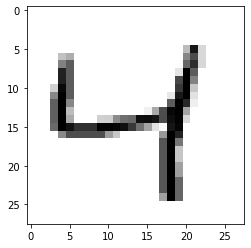

In [ ]:
plt.imshow(adverserial_training_images_batch[2,:,:], cmap = plt.cm.binary)

In [ ]:
modified_predictions = mlp_model(adverserial_training_images_batch_modified)

In [ ]:
tf.argmax(modified_predictions, axis=1)

<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([5, 0, 4, ..., 3, 7, 7])>

In [ ]:
x = tf.equal(adverserial_training_labels_batch, tf.cast(tf.argmax(modified_predictions, axis=1),  dtype=tf.dtypes.float32))
tf.reduce_sum(tf.cast(x, tf.int32))

<tf.Tensor: shape=(), dtype=int32, numpy=1004>

In [ ]:
def untargeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="multiply", index_of_num=2,
                      attack_type = "untargeted", targeted_attack_images = None, loss_fnc = "CCE"):
  
  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    #Get the weighted gradient/maximum change of the individual image pixel wrt output prediction. weighted by 0.071
    if(i == 0):
      gradient, perturbations = create_adversarial_pattern(adverserial_training_images_batch, adverserial_training_labels_batch, perturbation_type, attack_type, loss_fnc=loss_fnc)
    else:
      gradient, perturbations = create_adversarial_pattern(adverserial_training_images_batch_modified, modified_predictions_2, perturbation_type, attack_type, loss_fnc=loss_fnc)

    #Add the gradient instead of subtracting it as we are trying to maximize the loss and moving in opposite direction of convex optimization hill.
    adverserial_training_images_batch_modified = tf.add(adverserial_training_images_batch, 1 * perturbations)

    #Get the new predictions for each change
    modified_predictions = mlp_model(adverserial_training_images_batch_modified)
    modified_predictions_2 =  tf.cast(tf.argmax(modified_predictions, axis=1),  dtype=tf.dtypes.float32)

    #Get the number of correct classifications to monitor misclassifications and see gradual changes
    x = tf.equal(adverserial_training_labels_batch, modified_predictions_2)
    print("Number of correct classifications, prediction of first image and counter are: {}, {} and {}".format(tf.reduce_sum(tf.cast(x, tf.int32)), modified_predictions_2[index_of_num], i))
    #print("Prediction of first image is : {}".format(modified_predictions_2[0]))
    plt.imshow(adverserial_training_images_batch_modified[index_of_num], cmap=plt.cm.binary)
  
  return;

Number of correct classifications, prediction of first image and counter are: 781, 4.0 and 0
Number of correct classifications, prediction of first image and counter are: 830, 4.0 and 1
Number of correct classifications, prediction of first image and counter are: 804, 4.0 and 2
Number of correct classifications, prediction of first image and counter are: 857, 4.0 and 3
Number of correct classifications, prediction of first image and counter are: 743, 9.0 and 4
Number of correct classifications, prediction of first image and counter are: 921, 4.0 and 5
Number of correct classifications, prediction of first image and counter are: 747, 4.0 and 6
Number of correct classifications, prediction of first image and counter are: 840, 4.0 and 7
Number of correct classifications, prediction of first image and counter are: 825, 4.0 and 8
Number of correct classifications, prediction of first image and counter are: 859, 4.0 and 9
Number of correct classifications, prediction of first image and count

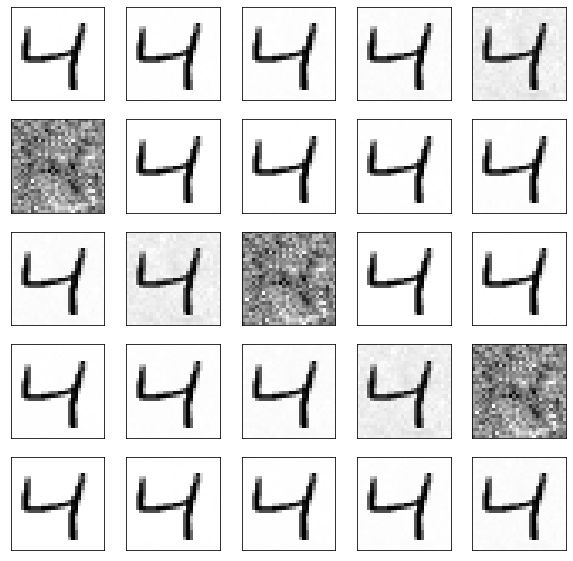

In [ ]:
untargeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="multiply")

Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 941, 8.0 and 0
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 970, 2.0 and 1
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 953, 8.0 and 2
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 971, 2.0 and 3
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 944, 8.0 and 4
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 982, 2.0 and 5
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 944, 8.0 and 6
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 975, 2.0 and 7
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 963, 8.0 and 8
Inside MSE loss
Num

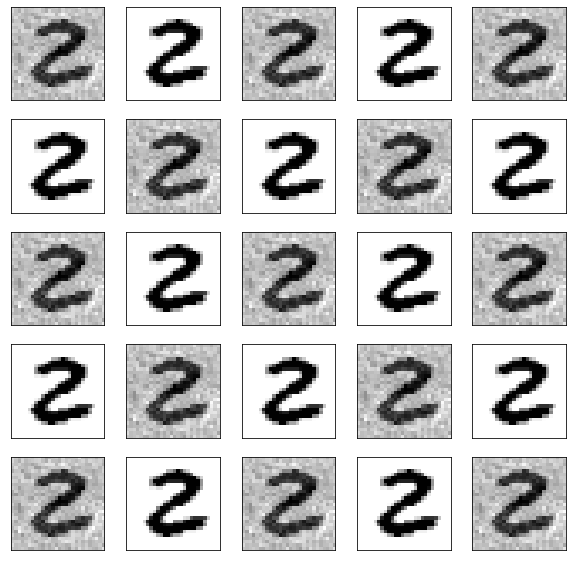

In [ ]:
untargeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="multiply", loss_fnc = "MSE", index_of_num=25 )

Number of correct classifications, prediction of first image and counter are: 977, 8.0 and 0
Number of correct classifications, prediction of first image and counter are: 1009, 2.0 and 1
Number of correct classifications, prediction of first image and counter are: 983, 8.0 and 2
Number of correct classifications, prediction of first image and counter are: 1008, 2.0 and 3
Number of correct classifications, prediction of first image and counter are: 979, 8.0 and 4
Number of correct classifications, prediction of first image and counter are: 1012, 2.0 and 5
Number of correct classifications, prediction of first image and counter are: 978, 8.0 and 6
Number of correct classifications, prediction of first image and counter are: 1011, 2.0 and 7
Number of correct classifications, prediction of first image and counter are: 982, 8.0 and 8
Number of correct classifications, prediction of first image and counter are: 1006, 2.0 and 9
Number of correct classifications, prediction of first image and 

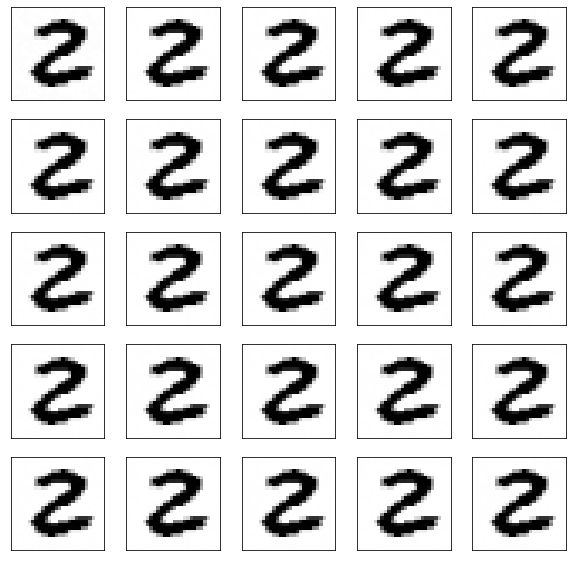

In [ ]:
untargeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="gradient_sign", index_of_num=25)

Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 977, 8.0 and 0
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 1009, 2.0 and 1
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 983, 8.0 and 2
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 1006, 2.0 and 3
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 981, 8.0 and 4
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 1011, 2.0 and 5
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 979, 8.0 and 6
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 1009, 2.0 and 7
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 982, 8.0 and 8
Inside MSE loss

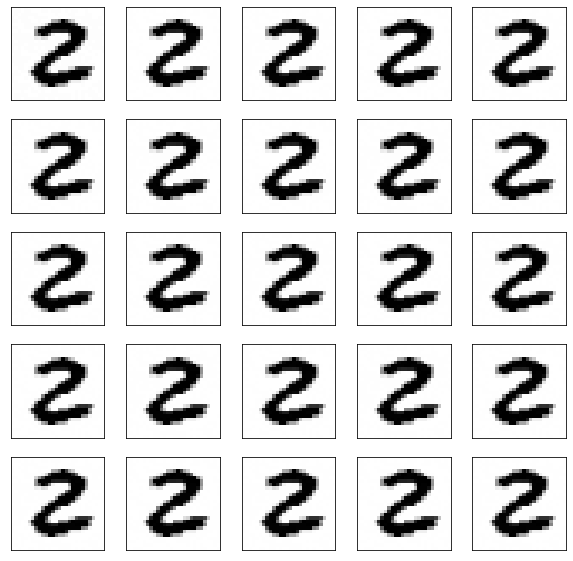

In [ ]:
untargeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="gradient_sign", loss_fnc = "MSE", index_of_num=25 )

Number of correct classifications, prediction of first image and counter are: 884, 0.0 and 0
Number of correct classifications, prediction of first image and counter are: 887, 0.0 and 1
Number of correct classifications, prediction of first image and counter are: 884, 0.0 and 2
Number of correct classifications, prediction of first image and counter are: 887, 0.0 and 3
Number of correct classifications, prediction of first image and counter are: 884, 0.0 and 4
Number of correct classifications, prediction of first image and counter are: 887, 0.0 and 5
Number of correct classifications, prediction of first image and counter are: 884, 0.0 and 6
Number of correct classifications, prediction of first image and counter are: 887, 0.0 and 7
Number of correct classifications, prediction of first image and counter are: 884, 0.0 and 8
Number of correct classifications, prediction of first image and counter are: 887, 0.0 and 9
Number of correct classifications, prediction of first image and count

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


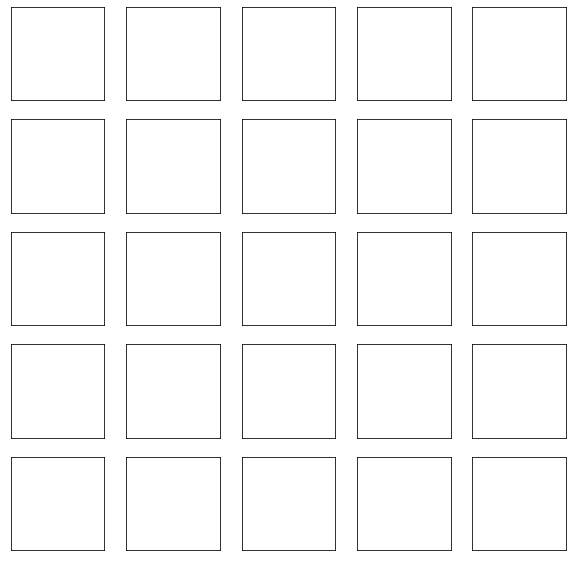

In [ ]:
untargeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="unit_vector", index_of_num=1)

Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 946, 0.0 and 0
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 949, 0.0 and 1
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 946, 0.0 and 2
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 949, 0.0 and 3
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 946, 0.0 and 4
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 949, 0.0 and 5
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 946, 0.0 and 6
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 949, 0.0 and 7
Inside MSE loss
Number of correct classifications, prediction of first image and counter are: 946, 0.0 and 8
Inside MSE loss
Num

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


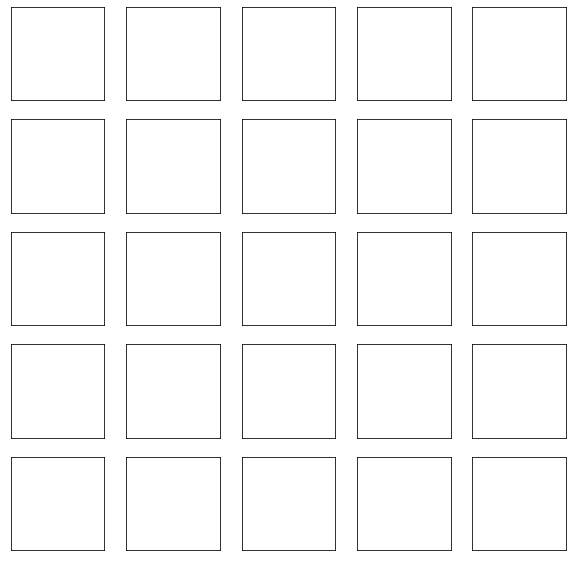

In [ ]:
untargeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="unit_vector", index_of_num=1, loss_fnc = "MSE" )

**Targeted Attack: Cost Function**

We are trying to change the prediction and also making the source image more similar to target image. Lambda is a hyper parameter

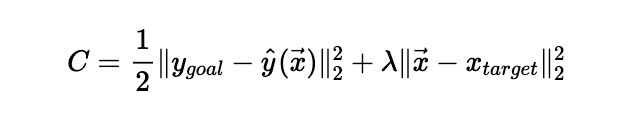

In [ ]:
tmp_stack = tf.concat(values = [tf.expand_dims(adverserial_training_images_batch[25, :, :], axis = 0), 
                               tf.expand_dims(adverserial_training_images_batch[25, :, :], axis = 0 )] , axis = 0)
tmp_stack

<tf.Tensor: shape=(2, 28, 28), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [ ]:

targeted_attack_images = tf.repeat(tf.expand_dims(adverserial_training_images_batch[25, :, :], axis = 0), repeats=512, axis=0, name=None)
targeted_attack_images.shape


TensorShape([512, 28, 28])

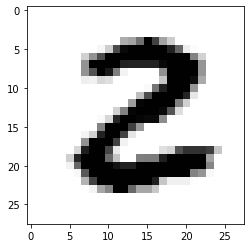

In [ ]:
plt.imshow(targeted_attack_images[25,:,:], cmap=plt.cm.binary)

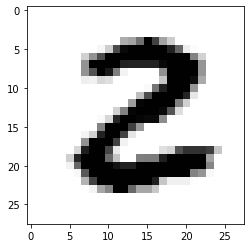

In [ ]:
plt.imshow(targeted_attack_images[1,:,:], cmap=plt.cm.binary)

In [ ]:
def targeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="multiply", index_of_num=2,
                     attack_type = "targeted", targeted_attack_images = targeted_attack_images, loss_fnc = "CCE", lmbda = 0.05, multiply_factor= 100000):

  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    #Get the weighted gradient/maximum change of the individual image pixel wrt output prediction. weighted by 0.071
    if(i == 0):
      gradient, perturbations = create_adversarial_pattern(adverserial_training_images_batch, adverserial_training_labels_batch, perturbation_type, attack_type = "targeted", targeted_attack_images = targeted_attack_images, loss_fnc = "MSE", lmbda=lmbda, multiply_factor= multiply_factor)
    else:
      gradient, perturbations = create_adversarial_pattern(adverserial_training_images_batch_modified, modified_predictions_2, perturbation_type, attack_type = "targeted", targeted_attack_images = targeted_attack_images, loss_fnc = "MSE", lmbda = lmbda, multiply_factor=multiply_factor)

    #Add the gradient instead of subtracting it as we are trying to maximize the loss and moving in opposite direction of convex optimization hill.
    adverserial_training_images_batch_modified = tf.subtract(adverserial_training_images_batch, 1 * perturbations)

    #Get the new predictions for each change
    modified_predictions = mlp_model(adverserial_training_images_batch_modified)
    modified_predictions_2 =  tf.cast(tf.argmax(modified_predictions, axis=1),  dtype=tf.dtypes.float32)

    #Get the number of correct classifications to monitor misclassifications and see gradual changes
    x = tf.equal(adverserial_training_labels_batch, modified_predictions_2)
    print("Number of correct classifications, prediction of first image and counter are: {}, {} and {}".format(tf.reduce_sum(tf.cast(x, tf.int32)), modified_predictions_2[index_of_num], i))
    #print("Prediction of first image is : {}".format(modified_predictions_2[0]))
    plt.imshow(adverserial_training_images_batch_modified[index_of_num], cmap=plt.cm.binary)
  
  return;

Number of correct classifications, prediction of first image and counter are: 79, 2.0 and 0
Number of correct classifications, prediction of first image and counter are: 362, 7.0 and 1
Number of correct classifications, prediction of first image and counter are: 79, 2.0 and 2
Number of correct classifications, prediction of first image and counter are: 362, 7.0 and 3
Number of correct classifications, prediction of first image and counter are: 79, 2.0 and 4
Number of correct classifications, prediction of first image and counter are: 362, 7.0 and 5
Number of correct classifications, prediction of first image and counter are: 79, 2.0 and 6
Number of correct classifications, prediction of first image and counter are: 362, 7.0 and 7
Number of correct classifications, prediction of first image and counter are: 79, 2.0 and 8
Number of correct classifications, prediction of first image and counter are: 362, 7.0 and 9
Number of correct classifications, prediction of first image and counter ar

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


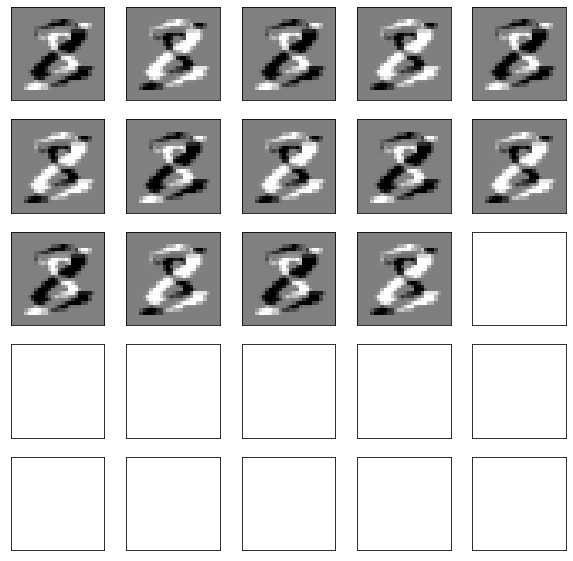

In [ ]:
targeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="multiply", index_of_num=0)

Number of correct classifications, prediction of first image and counter are: 213, 2.0 and 0
Number of correct classifications, prediction of first image and counter are: 700, 5.0 and 1
Number of correct classifications, prediction of first image and counter are: 279, 2.0 and 2
Number of correct classifications, prediction of first image and counter are: 457, 8.0 and 3
Number of correct classifications, prediction of first image and counter are: 323, 2.0 and 4
Number of correct classifications, prediction of first image and counter are: 405, 8.0 and 5
Number of correct classifications, prediction of first image and counter are: 348, 2.0 and 6
Number of correct classifications, prediction of first image and counter are: 379, 2.0 and 7
Number of correct classifications, prediction of first image and counter are: 360, 2.0 and 8
Number of correct classifications, prediction of first image and counter are: 372, 2.0 and 9
Number of correct classifications, prediction of first image and count

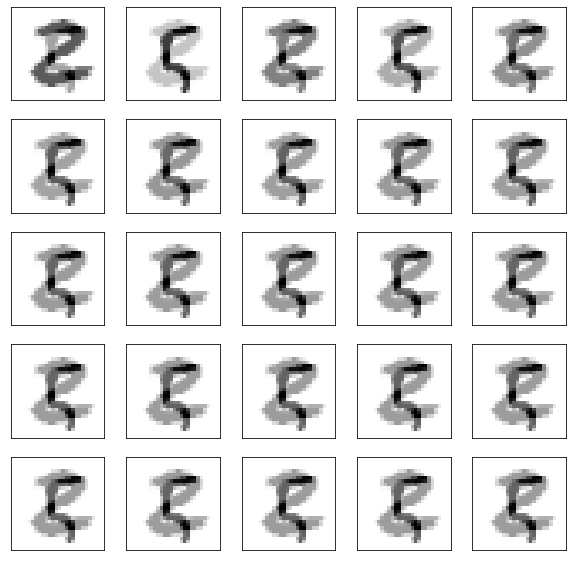

In [ ]:
targeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="multiply", index_of_num=100, lmbda=0.9, multiply_factor=10)

In [ ]:
z = perturbations
print(z.shape)
z

(1024, 28, 28)


<tf.Tensor: shape=(1024, 28, 28), dtype=float32, numpy=
array([[[-2.74132378e-03,  5.38331503e-03,  1.75640627e-03, ...,
          5.08194882e-03, -5.70606953e-03,  6.00808859e-03],
        [ 4.00201697e-03,  7.72786268e-04,  2.05669855e-03, ...,
         -2.12434819e-03,  1.67488563e-03,  9.70114139e-04],
        [-5.48428250e-03, -1.08808596e-02, -3.58962570e-03, ...,
          6.02121931e-03,  1.15031498e-02,  4.24643559e-03],
        ...,
        [ 2.13877647e-03, -6.29829895e-03, -5.30824240e-04, ...,
          4.05702798e-04, -1.52578782e-02, -4.49750340e-03],
        [ 2.23302958e-03,  1.18627714e-03,  7.17322051e-04, ...,
         -6.94958353e-03,  2.42668879e-03,  1.06545351e-02],
        [-5.17683744e-04, -1.24431332e-03, -3.75148980e-03, ...,
         -1.66693842e-03,  1.21957378e-03,  7.77785014e-03]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.0

In [ ]:

norm = tf.sqrt(tf.reduce_sum(tf.square(perturbations), axis=[-1,-2], keepdims=True))
print(norm)
#assert norm.shape == [100, 1]

res = z / norm

tf.Tensor(
[[[1.7896293e-01]]

 [[0.0000000e+00]]

 [[7.0211840e-01]]

 ...

 [[3.2751392e+03]]

 [[7.7128544e+00]]

 [[2.4571011e+03]]], shape=(1024, 1, 1), dtype=float32)


In [ ]:
res

<tf.Tensor: shape=(1024, 28, 28), dtype=float32, numpy=
array([[[-0.01531783,  0.03008061,  0.00981436, ...,  0.02839666,
         -0.03188409,  0.03357169],
        [ 0.02236227,  0.00431814,  0.01149232, ..., -0.01187033,
          0.00935884,  0.00542075],
        [-0.0306448 , -0.06079952, -0.02005793, ...,  0.03364506,
          0.06427672,  0.02372802],
        ...,
        [ 0.01195095, -0.03519332, -0.00296611, ...,  0.00226697,
         -0.0852572 , -0.02513092],
        [ 0.01247761,  0.00662862,  0.00400822, ..., -0.03883253,
          0.01355973,  0.05953487],
        [-0.00289269, -0.00695291, -0.02096239, ..., -0.00931443,
          0.00681467,  0.04346068]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...

In [ ]:
mlp_model.save("/content/mlp_model")

INFO:tensorflow:Assets written to: /content/mlp_model/assets


In [ ]:
!zip -r /content/mlp_model.zip /content/mlp_model

  adding: content/mlp_model/ (stored 0%)
  adding: content/mlp_model/variables/ (stored 0%)
  adding: content/mlp_model/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: content/mlp_model/variables/variables.index (deflated 65%)
  adding: content/mlp_model/assets/ (stored 0%)
  adding: content/mlp_model/saved_model.pb (deflated 88%)


# Activation Maximization

**Reference:** https://www.sicara.ai/blog/2019-08-28-interpretability-deep-learning-tensorflow

We see from the activation maximization, that differene between original and updated image, the pixels that maximally activate 5(in color black) and not activate 5(in white)

**Possible attack of another type: Greedy attack**

We take inspiration from one pixel attack, but instead of implementing the difficult algorithm, We first take and image and find ts maximally active pixel positions. 

After that we are going to start blanking out these positions one by one and see hown many pixels does it take for missclassification

In [ ]:
# Initiate random noise
input_img_data = np.random.random((1, 28, 28))
input_img_data = (input_img_data - 0.5) * 20 + 128.
epochs = 10000
step_size = 1.
filter_index = 0

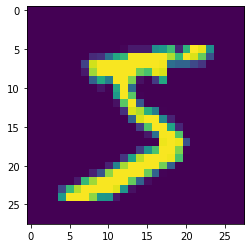

In [ ]:
plt.imshow(adverserial_training_images_batch[0,:,:])

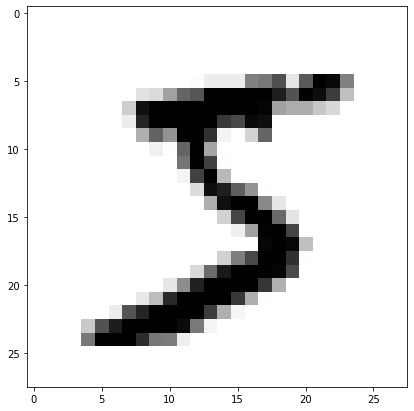

In [ ]:
# Cast random noise from np.float64 to tf.float32 Variable
input_img_data = tf.Variable(tf.cast(tf.expand_dims(adverserial_training_images_batch[0,:,:], axis=0), tf.float32))
plt.figure(figsize=(7,7))

# Iterate gradient ascents
for i in range(epochs):
  
  with tf.GradientTape() as tape:
      outputs = mlp_model(input_img_data)
      loss_value = tf.reduce_mean(outputs)
  grads = tape.gradient(loss_value, input_img_data)
  normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
  input_img_data.assign_add(normalized_grads * 2)
  #print(input_img_data)
  """
  plt.subplot(12,12,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(tf.convert_to_tensor(input_img_data[0,:,:], dtype=tf.dtypes.float32), cmap=plt.cm.binary)
  """
plt.imshow(tf.convert_to_tensor(input_img_data[0,:,:], dtype=tf.dtypes.float32), cmap=plt.cm.binary)

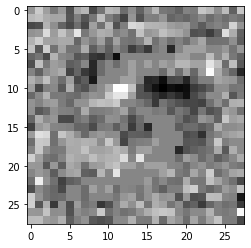

In [ ]:
x = tf.subtract(input_img_data, tf.Variable(tf.cast(tf.expand_dims(adverserial_training_images_batch[0,:,:], axis=0), tf.float32)))
plt.imshow(tf.convert_to_tensor(x[0,:,:], dtype=tf.dtypes.float32) , cmap=plt.cm.binary)

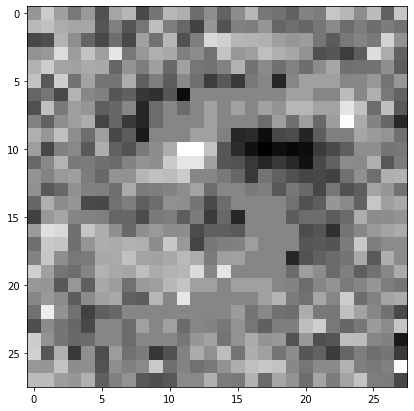

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(tf.convert_to_tensor(x[0,:,:], dtype=tf.dtypes.float32) , cmap=plt.cm.binary)

# Adverserial Training

Integrate the adversarial example procedure in the model’s training loop. That is, at each step, run the current batch through the model and use it to create a batch of adversarial examples. Also run this batch through the model and compute the loss. You can now update your network on this “double batch” of normal and adversarial examples (you could even try training using only adversarial examples). - **Yes we trained only using adverserial examples**


Test the network on some new adversarial examples, created using the same method that was used during training. It should now be much less susceptible than without adversarial training. Ideally, compare accuracies over a large “test set” of adversarial examples. - **Yes we recieved around 80% test accuracy on an average, as we can see the image at index 2 has some noise which could have been classified as something else, now netwrk is classifying it as 7, the images at index 3,4 are anyway gibberish so its output doesn't matter much**

Also, does adversarial training affect performance on the original data? - **In our current example it seems to be not the case, but a paper provided in the reference link suggests otherwise**

**Bonus:** See if the adversarially trained network is also robust to other methods of attack (if you came up with any), or e.g. using multiple gradient steps to create the examples as proposed further above. - **Yes we tested the targeted adverserial examples on the model which was trained on untargeted example, as we can see that before the image was classified as 2 which is the target class, after pretraining with untartgeted adverserial example, the same image is classified more as 8 and less as 2, but errors still exists. This suggest that training on one adverserial example might help for other cases, but not completely, We can see that from targeted adverserial example, the source image 5 is being morphed to target image 2, but interestingky we don't get 2 as output in most cases. But still we won't get 5 too, we are getting 8. This does tell us that one type of adverserial example will partially succeed in breaking model which is trained on another type of adverserial example**

Yes we tried predicting for the greedy adverserial examples on the network that has been trained for untargeted attacks.



In [ ]:
!unzip "/content/mlp_model_adverserial_networks.zip"

Archive:  /content/mlp_model_adverserial_networks.zip
   creating: content/mlp_model/
   creating: content/mlp_model/variables/
  inflating: content/mlp_model/variables/variables.data-00000-of-00001  
  inflating: content/mlp_model/variables/variables.index  
   creating: content/mlp_model/assets/
  inflating: content/mlp_model/saved_model.pb  


In [ ]:
adverserial_training_images_batch = tf.convert_to_tensor(train_images[0:1024, :, :], dtype=tf.float32)
adverserial_training_images_batch2 = tf.convert_to_tensor(train_images[1024:4096, :, :], dtype=tf.float32)
adverserial_test_images_batch = tf.convert_to_tensor(test_images[0:1024, :, :], dtype=tf.float32)
adverserial_training_labels_batch = tf.convert_to_tensor(train_labels[0:1024], dtype=tf.float32)
adverserial_training_labels_batch2 = tf.convert_to_tensor(train_labels[1024:4096], dtype=tf.float32)
adverserial_test_labels_batch = tf.convert_to_tensor(test_labels[0:1024], dtype=tf.float32)
complete_training_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
complete_training_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
complete_test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)
complete_test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
print(adverserial_training_images_batch.shape)
print(adverserial_test_images_batch.shape)
print(adverserial_training_labels_batch.shape)
print(adverserial_test_labels_batch.shape)

(1024, 28, 28)
(1024, 28, 28)
(1024,)
(1024,)


In [ ]:
test_onehot = tf.one_hot(indices = tf.cast(adverserial_test_labels_batch, dtype=tf.dtypes.int64), depth=10)
print(test_onehot)
test_onehot.shape

tf.Tensor(
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(1024, 10), dtype=float32)


TensorShape([1024, 10])

In [ ]:
mlp_model = tf.keras.models.load_model("/content/content/mlp_model")

In [ ]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
__________________________________________________

In [ ]:
def create_adversarial_pattern(adverserial_training_images_batch, adverserial_training_labels_batch, perturbation_type="multiply", 
                               attack_type = "untargeted", targeted_attack_images = None, loss_fnc = "CCE", lmbda = 0.05, multiply_factor=1000000):
  with tf.GradientTape() as tape:
    tape.watch(adverserial_training_images_batch)
    prediction = mlp_model(adverserial_training_images_batch)

    #Two loss functions for targeted and untargeted
    if(attack_type == "untargeted" and loss_fnc == "CCE"):
      loss = tf.keras.losses.sparse_categorical_crossentropy(adverserial_training_labels_batch, prediction)
    elif(attack_type == "untargeted" and loss_fnc == "MSE"):
      one_hot_test_labels = tf.one_hot(indices = tf.cast(adverserial_training_labels_batch, dtype=tf.dtypes.int64), depth=10)
      loss = tf.keras.losses.mean_squared_error(one_hot_test_labels, prediction)
    elif(attack_type == "targeted" and loss_fnc == "MSE"):
      one_hot_test_labels = tf.one_hot(indices = tf.cast(adverserial_training_labels_batch, dtype=tf.dtypes.int64), depth=10)
      #print(one_hot_test_labels.shape)
      #print(prediction.shape)
      #print(adverserial_training_images_batch.shape)
      #print(targeted_attack_images.shape)
      y_loss = lmbda * tf.keras.losses.mean_squared_error(adverserial_training_images_batch, targeted_attack_images)
      #print(y_loss.shape)
      targeting_image_loss = tf.reduce_sum(y_loss,axis = 1)
      #print(targeting_image_loss.shape)
      loss = tf.keras.losses.mean_squared_error(one_hot_test_labels, prediction) + targeting_image_loss
    else:
      print("Only two types of attacks are possible untargeted and targeted, you have given {}. Aborting".format(attack_type))
      return [None, None]

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, adverserial_training_images_batch)
  # Get the sign of the gradients to create the perturbation
  #signed_grad = tf.sign(gradient)
  if(perturbation_type == "multiply"):
    perturbations = multiply_factor * gradient
  elif(perturbation_type == "unit_vector"):
    z = gradient

    #In our implementation we forggot to add a small constant like 1*e-10, if number is less then tf.square will make it nan, hence gradiens will be NaN
    norm = tf.sqrt(tf.reduce_sum(tf.square(z), axis=[-1,-2], keepdims=True))
    perturbations = z/norm
  elif(perturbation_type == "gradient_sign"):
    perturbations = tf.sign(gradient)
  else:
    perturbations = gradient
  return [gradient, perturbations];

In [ ]:
def untargeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="multiply", index_of_num=2,
                      attack_type = "untargeted", targeted_attack_images = None, loss_fnc = "CCE"):
  
  plt.figure(figsize=(10,10))
  adverserial_training_images_modified_list = []
  adverserial_training_predictions_list = []
  actual_training_labels_list = []

  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    #Get the weighted gradient/maximum change of the individual image pixel wrt output prediction. weighted by 0.071
    if(i == 0):
      gradient, perturbations = create_adversarial_pattern(adverserial_training_images_batch, adverserial_training_labels_batch, perturbation_type, attack_type, loss_fnc=loss_fnc)
    else:
      gradient, perturbations = create_adversarial_pattern(adverserial_training_images_batch_modified, modified_predictions_2, perturbation_type, attack_type, loss_fnc=loss_fnc)

    #Add the gradient instead of subtracting it as we are trying to maximize the loss and moving in opposite direction of convex optimization hill.
    adverserial_training_images_batch_modified = tf.add(adverserial_training_images_batch, 1 * perturbations)
    

    #Get the new predictions for each change
    modified_predictions = mlp_model(adverserial_training_images_batch_modified)
    modified_predictions_2 =  tf.cast(tf.argmax(modified_predictions, axis=1),  dtype=tf.dtypes.float32)

    #append the examples and predictions to list that would be used later to integrate in training loop
    adverserial_training_images_modified_list.append(adverserial_training_images_batch_modified)
    adverserial_training_predictions_list.append(modified_predictions)
    actual_training_labels_list.append(adverserial_training_labels_batch)


    #Get the number of correct classifications to monitor misclassifications and see gradual changes
    x = tf.equal(adverserial_training_labels_batch, modified_predictions_2)
    print("Number of correct classifications, prediction of first image and counter are: {}, {} and {}".format(tf.reduce_sum(tf.cast(x, tf.int32)), modified_predictions_2[index_of_num], i))
    #print("Prediction of first image is : {}".format(modified_predictions_2[0]))
    plt.imshow(adverserial_training_images_batch_modified[index_of_num], cmap=plt.cm.binary)
  
  return [adverserial_training_images_modified_list, adverserial_training_predictions_list, actual_training_labels_list];

Number of correct classifications, prediction of first image and counter are: 781, 4.0 and 0
Number of correct classifications, prediction of first image and counter are: 830, 4.0 and 1
Number of correct classifications, prediction of first image and counter are: 804, 4.0 and 2
Number of correct classifications, prediction of first image and counter are: 857, 4.0 and 3
Number of correct classifications, prediction of first image and counter are: 743, 9.0 and 4
Number of correct classifications, prediction of first image and counter are: 921, 4.0 and 5
Number of correct classifications, prediction of first image and counter are: 747, 4.0 and 6
Number of correct classifications, prediction of first image and counter are: 840, 4.0 and 7
Number of correct classifications, prediction of first image and counter are: 825, 4.0 and 8
Number of correct classifications, prediction of first image and counter are: 859, 4.0 and 9
Number of correct classifications, prediction of first image and count

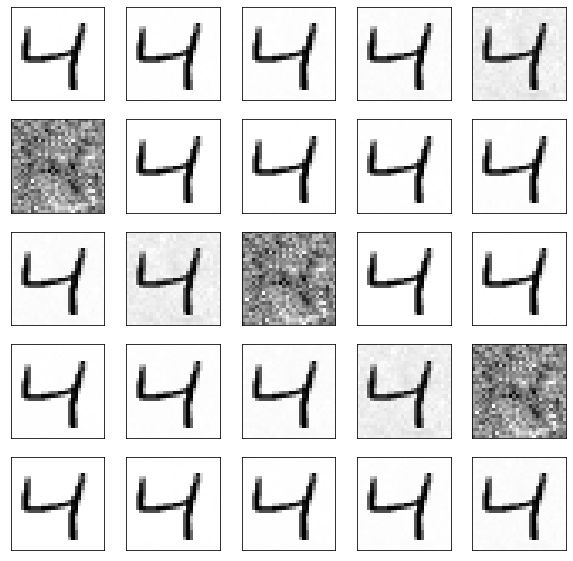

In [ ]:
adverserial_training_images_modified_list, adverserial_training_predictions_list, actual_training_labels_list = untargeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="multiply")

Number of correct classifications, prediction of first image and counter are: 46074, 4.0 and 0
Number of correct classifications, prediction of first image and counter are: 47917, 4.0 and 1
Number of correct classifications, prediction of first image and counter are: 46995, 4.0 and 2
Number of correct classifications, prediction of first image and counter are: 50053, 4.0 and 3
Number of correct classifications, prediction of first image and counter are: 43564, 9.0 and 4
Number of correct classifications, prediction of first image and counter are: 53310, 4.0 and 5
Number of correct classifications, prediction of first image and counter are: 43548, 4.0 and 6
Number of correct classifications, prediction of first image and counter are: 48799, 4.0 and 7
Number of correct classifications, prediction of first image and counter are: 48841, 4.0 and 8
Number of correct classifications, prediction of first image and counter are: 49487, 4.0 and 9
Number of correct classifications, prediction of f

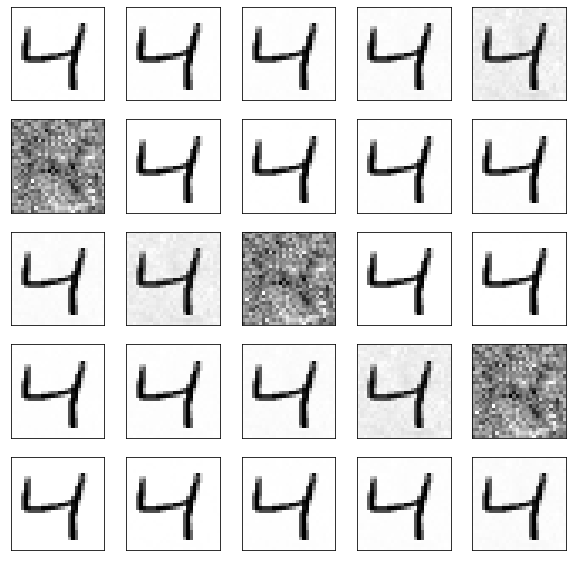

In [ ]:
complete_adverserial_training_images_modified_list, complete_adverserial_training_predictions_list, complete_actual_training_labels_list = untargeted_attack(complete_training_images, complete_training_labels,  perturbation_type="multiply")

In [ ]:
def compile_mlp_model(model,loss="CCE", metrics=["accuracy"], optimizer = "adam"):
  if(loss == "MAE"):
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MAE, metrics=metrics)
  elif (loss == "MSQE"):
    model.compile(optimizer=optimizer, loss=tf.keras.losses.mean_squared_error, metrics=metrics)
  elif (loss == "BCE"):
    model.compile(optimizer=optimizer, loss=tf.keras.losses.binary_crossentropy, metrics=metrics)
  elif(loss == "CCE"):
    model.compile(optimizer=optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=metrics)

In [ ]:
compile_mlp_model(mlp_model,loss="CCE")

In [ ]:
def adverserial_test_loop(adverserial_training_images_modified_list, actual_training_labels_list, test_images, test_labels, training_loops_lst= [3,4,5,6,10,11,12,13], epochs=3):
  for i in training_loops_lst:
    print("Starting loop for index: {}".format(i))
    mlp_model.fit(adverserial_training_images_modified_list[i], actual_training_labels_list[i],  epochs=epochs, batch_size=32, validation_data= (test_images, test_labels))
  
    

In [ ]:
adverserial_test_loop(complete_adverserial_training_images_modified_list, complete_actual_training_labels_list,  test_images, test_labels, epochs=3)

Starting loop for index: 3
Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9732 - accuracy: 0.8347 - val_loss: 0.1893 - val_accuracy: 0.9494
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3681 - accuracy: 0.8824 - val_loss: 0.1723 - val_accuracy: 0.9531
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2927 - accuracy: 0.9036 - val_loss: 0.1554 - val_accuracy: 0.9527
Starting loop for index: 4
Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5819 - accuracy: 0.7982 - val_loss: 0.2539 - val_accuracy: 0.9232
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5329 - accuracy: 0.8076 - val_loss: 0.1920 - val_accuracy: 0.9554
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5291 - accuracy: 0.8131 - val_loss: 0.2494 - val_accuracy: 0.9403
Starting loop for index: 5
Epoch 1/3
1875/1875 [==============================] - 6s 3ms

In [ ]:
mlp_model.save("/content/mlp_model_2")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/mlp_model_2/assets


In [ ]:
!zip -r "/content/mlp_model_2.zip" "/content/mlp_model_2"

  adding: content/mlp_model_2/ (stored 0%)
  adding: content/mlp_model_2/saved_model.pb (deflated 89%)
  adding: content/mlp_model_2/variables/ (stored 0%)
  adding: content/mlp_model_2/variables/variables.data-00000-of-00002 (deflated 81%)
  adding: content/mlp_model_2/variables/variables.index (deflated 66%)
  adding: content/mlp_model_2/variables/variables.data-00001-of-00002 (deflated 8%)
  adding: content/mlp_model_2/assets/ (stored 0%)


Number of correct classifications, prediction of first image and counter are: 7675, 7.0 and 0
Number of correct classifications, prediction of first image and counter are: 7800, 7.0 and 1
Number of correct classifications, prediction of first image and counter are: 7803, 3.0 and 2
Number of correct classifications, prediction of first image and counter are: 8259, 8.0 and 3
Number of correct classifications, prediction of first image and counter are: 7106, 7.0 and 4
Number of correct classifications, prediction of first image and counter are: 8799, 7.0 and 5
Number of correct classifications, prediction of first image and counter are: 7156, 7.0 and 6
Number of correct classifications, prediction of first image and counter are: 8000, 3.0 and 7
Number of correct classifications, prediction of first image and counter are: 8125, 8.0 and 8
Number of correct classifications, prediction of first image and counter are: 8149, 7.0 and 9
Number of correct classifications, prediction of first image

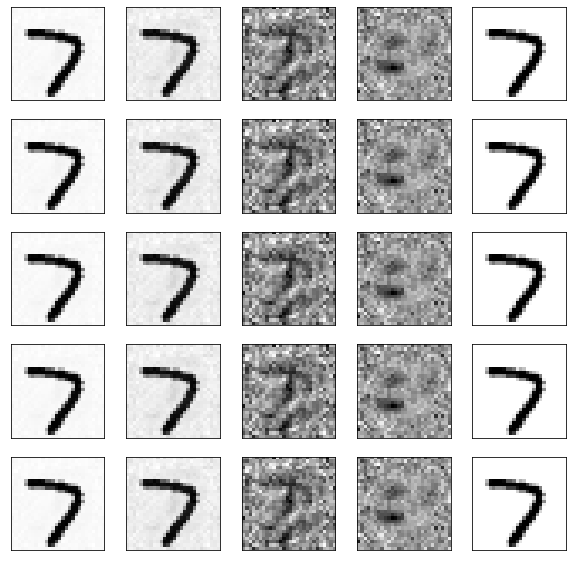

In [ ]:
complete_adverserial_testing_images_modified_list, complete_adverserial_testing_predictions_list, complete_actual_testing_labels_list = untargeted_attack( complete_test_images, complete_test_labels,  index_of_num=17,perturbation_type="multiply")

In [ ]:
targeted_attack_images = tf.repeat(tf.expand_dims(adverserial_training_images_batch[25, :, :], axis = 0), repeats=60000, axis=0, name=None)

In [ ]:
def targeted_attack(adverserial_training_images_batch, adverserial_training_labels_batch,  perturbation_type="multiply", index_of_num=2,
                     attack_type = "targeted", targeted_attack_images = targeted_attack_images, loss_fnc = "CCE", lmbda = 0.05, multiply_factor= 100000):

  plt.figure(figsize=(10,10))
  adverserial_training_images_modified_list = []
  adverserial_training_predictions_list = []
  actual_training_labels_list = []
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    #Get the weighted gradient/maximum change of the individual image pixel wrt output prediction. weighted by 0.071
    if(i == 0):
      gradient, perturbations = create_adversarial_pattern(adverserial_training_images_batch, adverserial_training_labels_batch, perturbation_type, attack_type = "targeted", targeted_attack_images = targeted_attack_images, loss_fnc = "MSE", lmbda=lmbda, multiply_factor= multiply_factor)
    else:
      gradient, perturbations = create_adversarial_pattern(adverserial_training_images_batch_modified, modified_predictions_2, perturbation_type, attack_type = "targeted", targeted_attack_images = targeted_attack_images, loss_fnc = "MSE", lmbda = lmbda, multiply_factor=multiply_factor)

    #Add the gradient instead of subtracting it as we are trying to maximize the loss and moving in opposite direction of convex optimization hill.
    adverserial_training_images_batch_modified = tf.subtract(adverserial_training_images_batch, 1 * perturbations)

    #Get the new predictions for each change
    modified_predictions = mlp_model(adverserial_training_images_batch_modified)
    modified_predictions_2 =  tf.cast(tf.argmax(modified_predictions, axis=1),  dtype=tf.dtypes.float32)

    adverserial_training_images_modified_list.append(adverserial_training_images_batch_modified)
    adverserial_training_predictions_list.append(modified_predictions)
    actual_training_labels_list.append(adverserial_training_labels_batch)
    #Get the number of correct classifications to monitor misclassifications and see gradual changes
    x = tf.equal(adverserial_training_labels_batch, modified_predictions_2)
    print("Number of correct classifications, prediction of first image and counter are: {}, {} and {}".format(tf.reduce_sum(tf.cast(x, tf.int32)), modified_predictions_2[index_of_num], i))
    #print("Prediction of first image is : {}".format(modified_predictions_2[0]))
    plt.imshow(adverserial_training_images_batch_modified[index_of_num], cmap=plt.cm.binary)
  
  return [adverserial_training_images_modified_list, adverserial_training_predictions_list, actual_training_labels_list];

We can see that from targeted adverserial example, the source image 5 is being morphed to target image 2, but interestingky we don't get 2 as output in most cases. But still we won't get 5 too, we are getting 8. This does tell us that one type of adverserial example will partially succeed in breaking model which is trained on another type of adverserial example

Number of correct classifications, prediction of first image and counter are: 13059, 2.0 and 0
Number of correct classifications, prediction of first image and counter are: 41455, 8.0 and 1
Number of correct classifications, prediction of first image and counter are: 17615, 2.0 and 2
Number of correct classifications, prediction of first image and counter are: 27958, 8.0 and 3
Number of correct classifications, prediction of first image and counter are: 20255, 8.0 and 4
Number of correct classifications, prediction of first image and counter are: 24553, 8.0 and 5
Number of correct classifications, prediction of first image and counter are: 21613, 8.0 and 6
Number of correct classifications, prediction of first image and counter are: 23398, 8.0 and 7
Number of correct classifications, prediction of first image and counter are: 22188, 8.0 and 8
Number of correct classifications, prediction of first image and counter are: 22954, 8.0 and 9
Number of correct classifications, prediction of f

ResourceExhaustedError: ignored

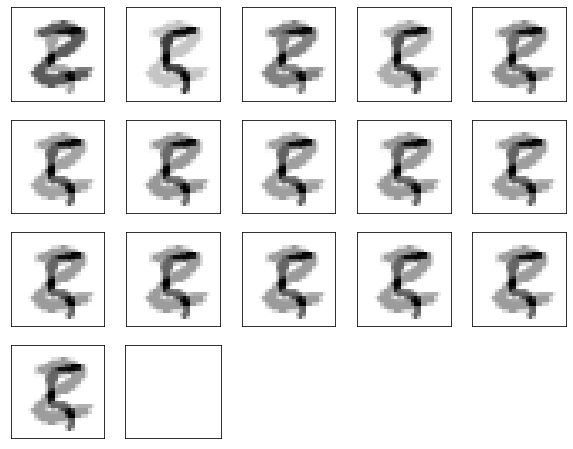

In [ ]:
at1, al1, aal1 = targeted_attack(complete_training_images, complete_training_labels,  perturbation_type="multiply", index_of_num=100, lmbda=0.9, multiply_factor=10)

As we can see our current model is unaffected by adverserial training

In [ ]:
mlp_model.evaluate(complete_training_images, complete_training_labels,return_dict=True)

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0593 - accuracy: 0.9850


{'accuracy': 0.9850000143051147, 'loss': 0.059324733912944794}

In [ ]:
mlp_model.evaluate(complete_test_images, complete_test_labels,return_dict=True)

313/313 [==============================] - 1s 3ms/step - loss: 0.1255 - accuracy: 0.9735


{'accuracy': 0.9735000133514404, 'loss': 0.12545140087604523}